In [223]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from utils import calculate_metric
from utils import run_kfold_eval
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

## Load Data

Load train and test predictions from base models, as well as the target labels.

In [224]:
# Load predictions from different models
training_file_name = '../output/oof_predictions.xlsx'
test_file_name = '../output/test_predictions.xlsx'


# Load actual labels
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/meta_learner'

Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

In [176]:
train_predictions_file = pd.ExcelFile(training_file_name)
test_predictions_file = pd.ExcelFile(test_file_name)

train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [142]:
# Display shapes
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1293, 1)
Test labels shape: (432, 1)


In [143]:
# Dictionary to store DataFrames from each sheet
training_predictions = pd.DataFrame()
test_predictions = {}
sheet_names = train_predictions_file.sheet_names

# Read each sheet and store in the dictionary
for sheet_name in sheet_names:
    print(f"Reading sheet: {sheet_name}")
    training = pd.read_excel(training_file_name, sheet_name=sheet_name)
    training_predictions[sheet_name] = training.values.ravel()

    test = pd.read_excel(test_file_name, sheet_name=sheet_name)
    test_predictions[sheet_name] = test.values.ravel()

Reading sheet: mlp
Reading sheet: resnet
Reading sheet: transformer
Reading sheet: random_forest
Reading sheet: svm
Reading sheet: xgboost
Reading sheet: lightgbm
Reading sheet: catboost
Reading sheet: lasso
Reading sheet: linear_regression
Reading sheet: ridge
Reading sheet: ExactGP
Reading sheet: tabpfn
Reading sheet: GANDALF
Reading sheet: beta


In [144]:
training_predictions = pd.DataFrame(training_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [145]:
training_predictions.head()

,mlp,resnet,transformer,random_forest,svm,xgboost,lightgbm,catboost,lasso,linear_regression,ridge,ExactGP,tabpfn,GANDALF,beta
0,0.297336,0.003034,0.083570,0.085073,0.259998,0.087159,0.096149,0.065221,0.280091,0.147726,0.200306,0.064798,0.081902,0.067501,0.232964
1,0.560364,0.473622,0.288102,0.651730,0.407463,0.537473,0.477985,0.520107,0.431302,0.363599,0.426023,0.530702,0.582797,0.548563,0.528458
2,0.806250,0.827493,0.849690,0.894259,0.891207,0.915407,0.859127,0.871453,0.736495,0.859616,0.761234,0.875019,0.908666,0.864264,0.810991
3,0.808729,0.961694,0.872598,0.940343,0.826876,0.997367,1.003401,1.010926,0.659543,0.775557,0.767175,1.001151,0.949204,0.926075,0.696612
4,0.730610,1.035393,1.073326,0.982974,0.898631,1.034883,0.986328,1.067743,0.778886,0.925603,0.870509,1.027771,0.999565,0.964049,0.885558


In [146]:
test_predictions.head()

,mlp,resnet,transformer,random_forest,svm,xgboost,lightgbm,catboost,lasso,linear_regression,ridge,ExactGP,tabpfn,GANDALF,beta
0,0.253383,0.081924,0.088552,0.185432,-0.014708,0.062454,0.044459,0.055346,0.290340,0.043113,0.014236,0.095428,0.159902,0.242045,0.181104
1,0.549668,0.469224,0.616741,0.524908,0.714150,0.532627,0.525890,0.498200,0.624681,0.623876,0.637774,0.528721,0.566303,0.639768,0.615051
2,0.255807,0.457248,0.312363,0.528934,0.482329,0.657036,0.610772,0.723870,0.449411,1.003061,0.983362,0.519348,0.585768,0.290754,0.597571
3,0.419227,0.317480,0.536766,0.395500,0.492501,0.383120,0.374060,0.370796,0.380007,0.312219,0.322881,0.469922,0.372286,0.426264,0.334203
4,0.809611,0.917092,0.801963,0.764115,0.814135,0.787736,0.749815,0.872356,0.479921,0.806155,0.673490,0.770240,0.662272,0.696281,0.542662


In [147]:
train_labels.shape

(1293, 1)

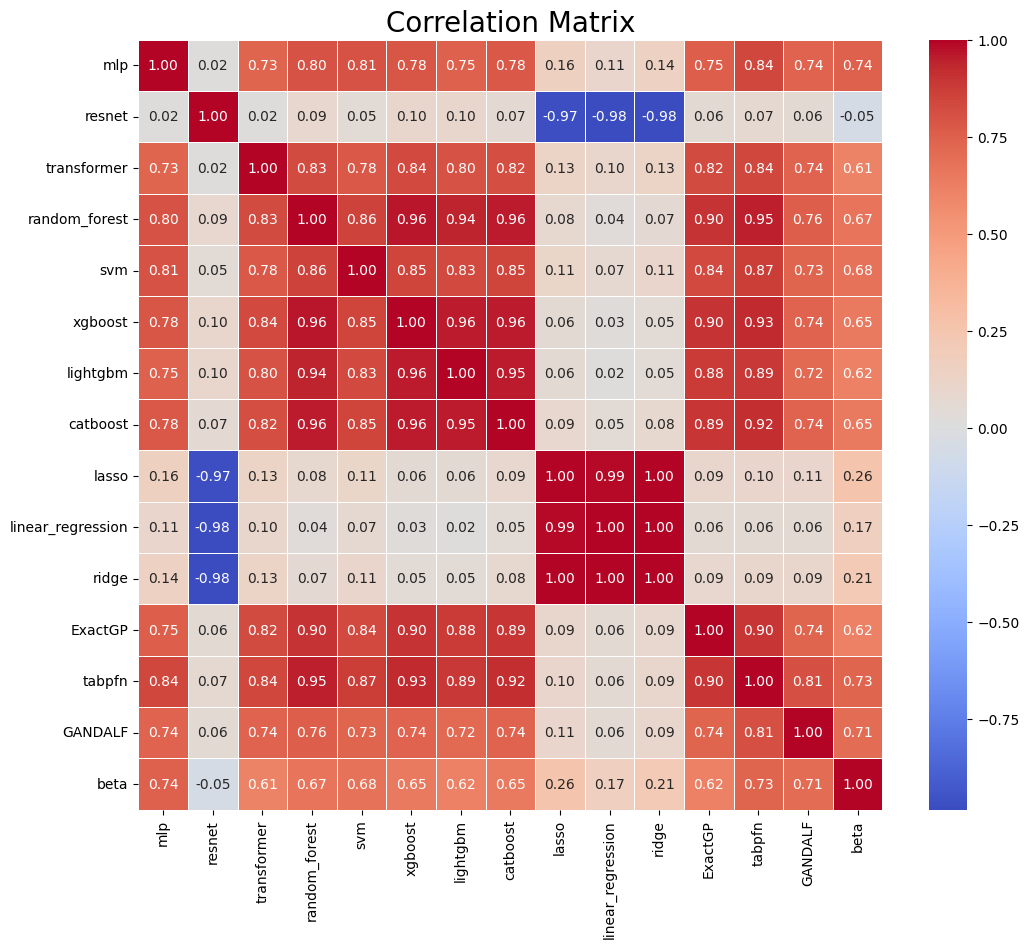

In [148]:
# correlation matrix
correlation_matrix = training_predictions.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

# Adjustments for aesthetics
plt.title('Correlation Matrix', fontsize=20)
plt.show()

In [177]:
meta_model = xgb.XGBRegressor(random_state=42)
meta_model.fit(training_predictions, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [178]:
# Make predictions
meta_train_predictions = meta_model.predict(training_predictions)
meta_test_predictions = meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.4f}")


Training Metrics:
MAE: 0.0080
MAPE: 126.9443%
RMSE: 0.0202
R2: 0.9962

Test Metrics:
MAE: 0.1551
MAPE: 234.0069%
RMSE: 0.2321
R2: 0.5298


In [179]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': sheet_names,
    'Importance': meta_model.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

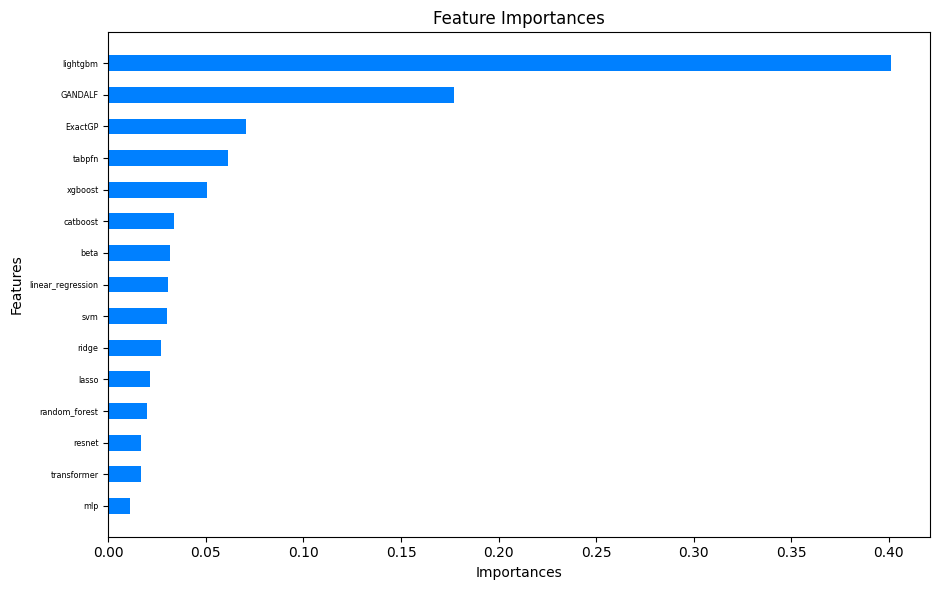

In [180]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

RIDGE AS META-LEARNER

In [181]:


# Train the final model on the entire training data
ridge_meta_model = Ridge(random_state=42)

ridge_meta_model.fit(training_predictions, train_labels)


Ridge(random_state=42)

In [182]:
# Make predictions
meta_train_predictions = ridge_meta_model.predict(training_predictions)
meta_test_predictions = ridge_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.3409
MAPE: 4654.3990%
RMSE: 0.2051
R2: 0.6122

Test Metrics:
MAE: 0.3558
MAPE: 415.4362%
RMSE: 0.2162
R2: 0.59206


In [183]:
non_zero_coeff = []
non_zero_features = []
coef = ridge_meta_model.coef_
for index, value in enumerate(coef.ravel()):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(sheet_names[index])

In [184]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

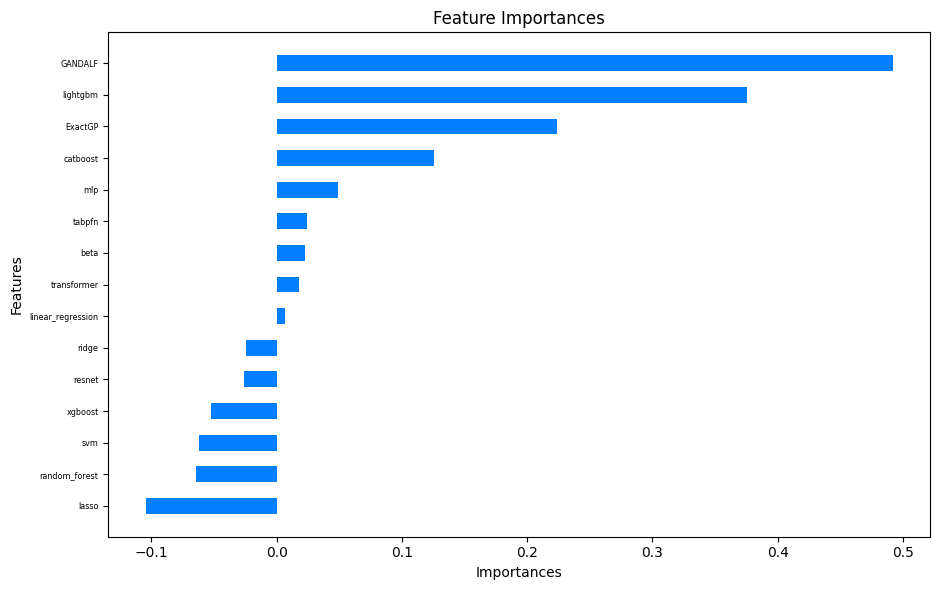

In [185]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

Hyperparameter tuning

In [186]:
from sklearn.model_selection import cross_val_score


def objective(trial):

    alpha = trial.suggest_float('alpha', 0.01, 100, log=True)
    
    # Create the pipeline with the current hyperparameters
    model = Ridge(random_state=42, alpha=alpha)
    score = cross_val_score(model, training_predictions, train_labels, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [187]:
import optuna


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-05-07 10:59:11,525] A new study created in memory with name: no-name-7b39b8f0-14ba-43ce-9f2b-fba1157048dc


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-07 10:59:16,010] Trial 0 finished with value: -0.0439712790848473 and parameters: {'alpha': 10.685840818357615}. Best is trial 0 with value: -0.0439712790848473.
[I 2025-05-07 10:59:16,773] Trial 1 finished with value: -0.043797485933916434 and parameters: {'alpha': 0.01761106396314402}. Best is trial 1 with value: -0.043797485933916434.
[I 2025-05-07 10:59:17,419] Trial 2 finished with value: -0.04371293452571291 and parameters: {'alpha': 0.30304987692041574}. Best is trial 2 with value: -0.04371293452571291.
[I 2025-05-07 10:59:17,445] Trial 3 finished with value: -0.04397972365263544 and parameters: {'alpha': 10.796136441840746}. Best is trial 2 with value: -0.04371293452571291.
[I 2025-05-07 10:59:17,460] Trial 4 finished with value: -0.04378755406617361 and parameters: {'alpha': 0.04700549327164277}. Best is trial 2 with value: -0.04371293452571291.
[I 2025-05-07 10:59:17,477] Trial 5 finished with value: -0.04598475719486569 and parameters: {'alpha': 43.93569542658178}

In [188]:
study.best_params

{'alpha': 2.680503576615634}

In [189]:
# Train the final model on the entire training data
ridge_meta_model = Ridge(random_state=42, **study.best_params)
ridge_meta_model.fit(training_predictions, train_labels)


Ridge(alpha=2.680503576615634, random_state=42)

In [190]:
# Make predictions
meta_train_predictions = ridge_meta_model.predict(training_predictions)
meta_test_predictions = ridge_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.3401
MAPE: 4653.6605%
RMSE: 0.2054
R2: 0.6111

Test Metrics:
MAE: 0.3545
MAPE: 414.0545%
RMSE: 0.2147
R2: 0.59774


In [191]:
non_zero_coeff = []
non_zero_features = []
coef = ridge_meta_model.coef_
for index, value in enumerate(coef.ravel()):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(sheet_names[index])

In [192]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

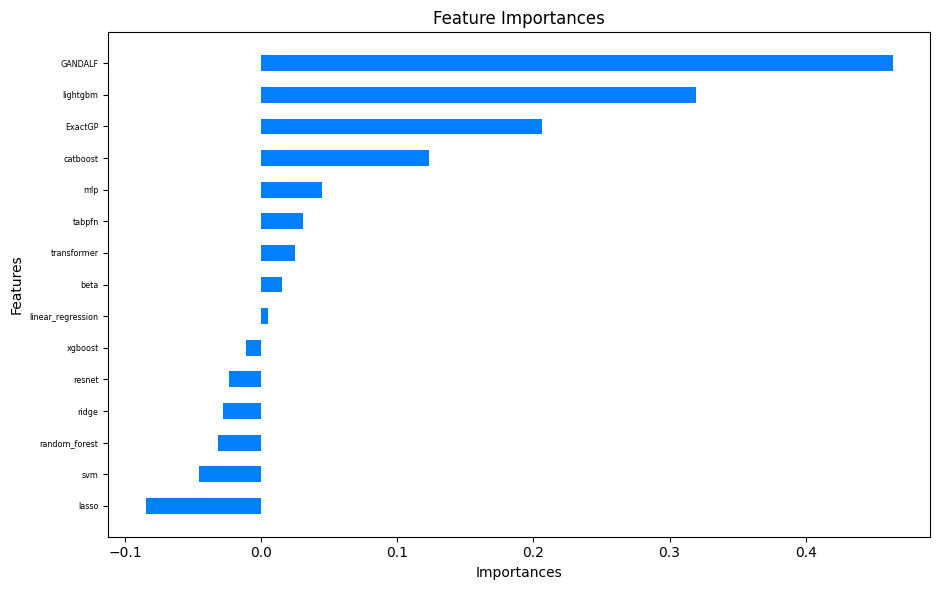

In [193]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

Lasso

In [149]:
# Train the final model on the entire training data
from sklearn.linear_model import Lasso


ridge_meta_model = Lasso(random_state=42)

ridge_meta_model.fit(training_predictions, train_labels)


Lasso(random_state=42)

In [150]:
# Make predictions
meta_train_predictions = ridge_meta_model.predict(training_predictions)
meta_test_predictions = ridge_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.2894
MAPE: 4640.7914%
RMSE: 0.3294
R2: 0.0000

Test Metrics:
MAE: 0.2979
MAPE: 381.7370%
RMSE: 0.3385
R2: -0.00015


In [156]:
def objective(trial):

    alpha = trial.suggest_float('alpha', 1e-5, 100, log=True)
    
    # Create the pipeline with the current hyperparameters
    model = Lasso(random_state=42, alpha=alpha)
    score = cross_val_score(model, training_predictions, train_labels, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [157]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-05-07 10:45:19,306] A new study created in memory with name: no-name-e6c3fb4e-786f-4c70-bf76-e710fafcfe0e


  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.695e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.571e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:19,342] Trial 0 finished with value: -0.04338712762026094 and parameters: {'alpha': 0.002373392797546228}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,358] Trial 1 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.7139107847538375}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,412] Trial 2 finished with value: -0.043734639721597635 and parameters: {'alpha': 3.795291160492436e-05}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,466] Trial 3 finished with value: -0.043782557489660937 and parameters: {'alpha': 1.0821526145188658e-05}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,480] Trial 4 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.14929517964464}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,497] Trial 5 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.2142056121449

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.482e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.657e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:19,548] Trial 6 finished with value: -0.043723101633892224 and parameters: {'alpha': 4.462681453516217e-05}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,576] Trial 7 finished with value: -0.0719359099634165 and parameters: {'alpha': 0.040805996396230726}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,592] Trial 8 finished with value: -0.1085148053872298 and parameters: {'alpha': 7.649548196340691}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,642] Trial 9 finished with value: -0.04378226587118312 and parameters: {'alpha': 1.0989806088047537e-05}. Best is trial 0 with value: -0.04338712762026094.
[I 2025-05-07 10:45:19,674] Trial 10 finished with value: -0.04337893809139869 and parameters: {'alpha': 0.001907852408431223}. Best is trial 10 with value: -0.04337893809139869.
[I 2025-05-07 10:45:19,707] Trial 11 finished with value: -0.0433730594913385 and parameters: {'alpha': 0.00131606

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.745e-02, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:20,063] Trial 19 finished with value: -0.04349700247524343 and parameters: {'alpha': 0.0001843642927885184}. Best is trial 14 with value: -0.04335862100803254.
[I 2025-05-07 10:45:20,095] Trial 20 finished with value: -0.1085148053872298 and parameters: {'alpha': 85.81915057244916}. Best is trial 14 with value: -0.04335862100803254.
[I 2025-05-07 10:45:20,139] Trial 21 finished with value: -0.043276431158731615 and parameters: {'alpha': 0.0009279467190780465}. Best is trial 21 with value: -0.043276431158731615.
[I 2025-05-07 10:45:20,168] Trial 22 finished with value: -0.04334300788392086 and parameters: {'alpha': 0.0003657488244181719}. Best is trial 21 with value: -0.043276431158731615.
[I 2025-05-07 10:45:20,222] Trial 23 finished with value: -0.04363164594564467 and parameters: {'alpha': 9.533968714373856e-05}. Best is trial 21 with value: -0.043276431158731615.
[I 2025-05-07 10:45:20,256] Trial 24 finished with value: -0.04328362096838536 and parameters: {'alph

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.236e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.479e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-05-07 10:45:20,286] Trial 25 finished with value: -0.04518609584068993 and parameters: {'alpha': 0.010143303346574766}. Best is trial 21 with value: -0.043276431158731615.
[I 2025-05-07 10:45:20,330] Trial 26 finished with value: -0.04327028102995882 and parameters: {'alpha': 0.000482711019817818}. Best is trial 26 with value: -0.04327028102995882.
[I 2025-05-07 10:45:20,361] Trial 27 finished with value: -0.043603025029982555 and parameters: {'alpha': 0.004188772889906846}. Best is trial 26 with value: -0.04327028102995882.
[I 2025-05-07 10:45:20,378] Trial 28 finished with value: -0.054629816408740574 and parameters: {'alpha': 0.025243777883244826}. Best is trial 26 with value: -0.04327028102995882.
[I 2025-05-07 10:45:20,409] Trial 29 finished with value: -0.04322146340258693 and parameters: {'alpha': 0.0007388196438253582}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,453] Trial 30 finished with value: -0.04372055184486549 and parameters: {'alph

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.453e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-05-07 10:45:20,503] Trial 32 finished with value: -0.04346460714091972 and parameters: {'alpha': 0.0031537966806727148}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,558] Trial 33 finished with value: -0.04363152502688675 and parameters: {'alpha': 9.540283360210976e-05}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,600] Trial 34 finished with value: -0.043271494680476065 and parameters: {'alpha': 0.0009150272741734026}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,628] Trial 35 finished with value: -0.07337544963772072 and parameters: {'alpha': 0.041911077595165054}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,659] Trial 36 finished with value: -0.04322374822706475 and parameters: {'alpha': 0.0007739363860548781}. Best is trial 29 with value: -0.04322146340258693.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e+01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.781e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:20,715] Trial 37 finished with value: -0.043755069966409835 and parameters: {'alpha': 2.6470250453217477e-05}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,769] Trial 38 finished with value: -0.04360927272443958 and parameters: {'alpha': 0.0001087268913753883}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,800] Trial 39 finished with value: -0.04365187953400246 and parameters: {'alpha': 0.004490935463777391}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,820] Trial 40 finished with value: -0.1085148053872298 and parameters: {'alpha': 0.16265208311321414}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,849] Trial 41 finished with value: -0.04323098735344868 and parameters: {'alpha': 0.0006137292210922914}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,880] Trial 42 finished with value: -0.043222773855949095 and parameters: {'alph

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+01, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e+00, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:20,928] Trial 44 finished with value: -0.04322176838556916 and parameters: {'alpha': 0.0007300032134566248}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,962] Trial 45 finished with value: -0.052857188569465044 and parameters: {'alpha': 0.023085208447235685}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:20,991] Trial 46 finished with value: -0.04338148938462827 and parameters: {'alpha': 0.002184871749388472}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:21,048] Trial 47 finished with value: -0.0437640600124558 and parameters: {'alpha': 2.1278921936254493e-05}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:21,088] Trial 48 finished with value: -0.043541468233859806 and parameters: {'alpha': 0.00015270581917041333}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:21,110] Trial 49 finished with value: -0.10829007017974604 and parameters: {'al

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.640e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-05-07 10:45:21,174] Trial 50 finished with value: -0.04370055637798464 and parameters: {'alpha': 5.76560915287443e-05}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:21,207] Trial 51 finished with value: -0.04322276305244098 and parameters: {'alpha': 0.0007073468726783174}. Best is trial 29 with value: -0.04322146340258693.
[I 2025-05-07 10:45:21,251] Trial 52 finished with value: -0.043221010757201694 and parameters: {'alpha': 0.0007555077812694171}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,279] Trial 53 finished with value: -0.04337916488997335 and parameters: {'alpha': 0.00200447958840177}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,310] Trial 54 finished with value: -0.043892047672720605 and parameters: {'alpha': 0.005751841425133098}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,344] Trial 55 finished with value: -0.04344528672658275 and parameters: {'al

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-05-07 10:45:21,632] Trial 61 finished with value: -0.043235088940081365 and parameters: {'alpha': 0.0005808941829584752}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,666] Trial 62 finished with value: -0.04338030141583259 and parameters: {'alpha': 0.0003114258978448504}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,683] Trial 63 finished with value: -0.043475212284867316 and parameters: {'alpha': 0.0032439364282860032}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,713] Trial 64 finished with value: -0.04331382530634725 and parameters: {'alpha': 0.0010256331053832353}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,745] Trial 65 finished with value: -0.043254397833532326 and parameters: {'alpha': 0.0005112732090398362}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,789] Trial 66 finished with value: -0.0435630202695157 and parameters

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.064e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.018e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(


[I 2025-05-07 10:45:21,847] Trial 68 finished with value: -0.04338109071336219 and parameters: {'alpha': 0.0015831897522847374}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,903] Trial 69 finished with value: -0.04369282709571548 and parameters: {'alpha': 6.212581004044415e-05}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,943] Trial 70 finished with value: -0.043223232950676135 and parameters: {'alpha': 0.0006985643987922625}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:21,984] Trial 71 finished with value: -0.043221525238704546 and parameters: {'alpha': 0.000736947343311145}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:22,029] Trial 72 finished with value: -0.04335380022953407 and parameters: {'alpha': 0.0003493847136047542}. Best is trial 52 with value: -0.043221010757201694.
[I 2025-05-07 10:45:22,059] Trial 73 finished with value: -0.04326137105473248 and parameters:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.438e+00, tolerance: 1.128e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+00, tolerance: 1.146e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

[I 2025-05-07 10:45:22,470] Trial 85 finished with value: -0.043658986319049874 and parameters: {'alpha': 8.02637804215913e-05}. Best is trial 81 with value: -0.043220981618505946.
[I 2025-05-07 10:45:22,544] Trial 86 finished with value: -0.043396595200843366 and parameters: {'alpha': 0.00029135993941633486}. Best is trial 81 with value: -0.043220981618505946.
[I 2025-05-07 10:45:22,572] Trial 87 finished with value: -0.04322140523360037 and parameters: {'alpha': 0.0007408617939860625}. Best is trial 81 with value: -0.043220981618505946.
[I 2025-05-07 10:45:22,604] Trial 88 finished with value: -0.043373323546392305 and parameters: {'alpha': 0.0013235181296860142}. Best is trial 81 with value: -0.043220981618505946.
[I 2025-05-07 10:45:22,649] Trial 89 finished with value: -0.04358717387661862 and parameters: {'alpha': 0.00012191207142557431}. Best is trial 81 with value: -0.043220981618505946.
[I 2025-05-07 10:45:22,679] Trial 90 finished with value: -0.04337664943183299 and paramete

In [158]:
study.best_params

{'alpha': 0.0007569906443619235}

In [159]:
# Train the final model on the entire training data
best_params = study.best_params
lasso_meta_model = Lasso(random_state=42, **best_params)

lasso_meta_model.fit(training_predictions, train_labels)


Lasso(alpha=0.0007569906443619235, random_state=42)

In [161]:
# Make predictions
meta_train_predictions = lasso_meta_model.predict(training_predictions)
meta_test_predictions = lasso_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.1462
MAPE: 4814.6422%
RMSE: 0.2057
R2: 0.6101

Test Metrics:
MAE: 0.1488
MAPE: 259.9470%
RMSE: 0.2155
R2: 0.59469


In [162]:
# Get the model coefficients
coef = lasso_meta_model.coef_

non_zero_coeff = []
non_zero_features = []
for index, value in enumerate(coef):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(training_predictions.columns[index])

In [163]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

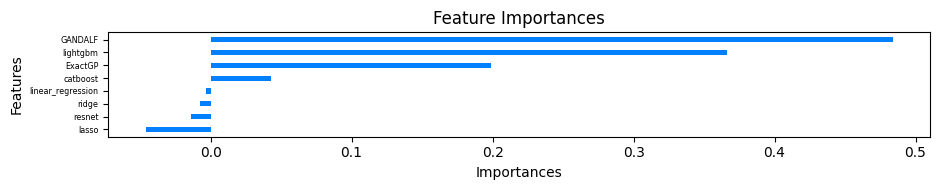

In [118]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

RF

In [194]:

# Instantiate model
from sklearn.ensemble import RandomForestRegressor


rf_meta_model = RandomForestRegressor()
# Train the model on training data
rf_meta_model.fit(training_predictions, train_labels)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [195]:
# Make predictions
meta_train_predictions = rf_meta_model.predict(training_predictions)
meta_test_predictions = rf_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.0523
MAPE: 2273.2356%
RMSE: 0.0777
R2: 0.9443

Test Metrics:
MAE: 0.1481
MAPE: 230.0350%
RMSE: 0.2194
R2: 0.57979


In [196]:
from sklearn.model_selection import train_test_split


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(training_predictions, train_labels, test_size=0.2, random_state=42)
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 200, 3000, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    n_jobs=-1
    )
    model.fit(train_x, train_y)

    # Make predictions and calculate RMSE
    predictions = model.predict(valid_x)
    mae, mape, rmse, rsqr = calculate_metric(predictions, valid_y.to_numpy())

    # Return MAE
    return rmse


In [197]:
# Create study object
study = optuna.create_study(direction="minimize")

# Run optimization process
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-05-07 10:59:32,497] A new study created in memory with name: no-name-da742340-8f08-4acc-bb14-f40468442355


  0%|          | 0/100 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:34,125] Trial 0 finished with value: 0.2252115761103205 and parameters: {'n_estimators': 1078, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2252115761103205.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:35,378] Trial 1 finished with value: 0.22551140970377537 and parameters: {'n_estimators': 579, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2252115761103205.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:38,844] Trial 2 finished with value: 0.2244336592220803 and parameters: {'n_estimators': 1790, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.2244336592220803.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:39,118] Trial 3 finished with value: 0.22954635199632856 and parameters: {'n_estimators': 206, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.2244336592220803.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:42,622] Trial 4 finished with value: 0.2229930846375712 and parameters: {'n_estimators': 1286, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:43,358] Trial 5 finished with value: 0.2238889566101471 and parameters: {'n_estimators': 202, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:48,214] Trial 6 finished with value: 0.22581641589874354 and parameters: {'n_estimators': 1434, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:51,502] Trial 7 finished with value: 0.22544188344982155 and parameters: {'n_estimators': 1401, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:51,961] Trial 8 finished with value: 0.22391095772529146 and parameters: {'n_estimators': 203, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:57,064] Trial 9 finished with value: 0.22420587735558414 and parameters: {'n_estimators': 2385, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 10:59:58,741] Trial 10 finished with value: 0.22336255474315 and parameters: {'n_estimators': 618, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:00,231] Trial 11 finished with value: 0.22347011235877276 and parameters: {'n_estimators': 614, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:01,439] Trial 12 finished with value: 0.2235465193012158 and parameters: {'n_estimators': 464, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:03,662] Trial 13 finished with value: 0.22347391391898777 and parameters: {'n_estimators': 894, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:04,374] Trial 14 finished with value: 0.2240159053857069 and parameters: {'n_estimators': 374, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.2229930846375712.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:09,286] Trial 15 finished with value: 0.2227400518509987 and parameters: {'n_estimators': 2802, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 15 with value: 0.2227400518509987.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:12,389] Trial 16 finished with value: 0.23770435643873097 and parameters: {'n_estimators': 2682, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 15 with value: 0.2227400518509987.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:15,784] Trial 17 finished with value: 0.2243376353973867 and parameters: {'n_estimators': 1980, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 15 with value: 0.2227400518509987.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:22,137] Trial 18 finished with value: 0.22303199569999954 and parameters: {'n_estimators': 2912, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 15 with value: 0.2227400518509987.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:24,536] Trial 19 finished with value: 0.2237363485297817 and parameters: {'n_estimators': 1193, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 15 with value: 0.2227400518509987.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:27,669] Trial 20 finished with value: 0.22240516810704797 and parameters: {'n_estimators': 1855, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 20 with value: 0.22240516810704797.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:30,822] Trial 21 finished with value: 0.22242372501908048 and parameters: {'n_estimators': 1829, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 20 with value: 0.22240516810704797.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:33,914] Trial 22 finished with value: 0.2223916827043011 and parameters: {'n_estimators': 1941, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:36,625] Trial 23 finished with value: 0.22278753705902543 and parameters: {'n_estimators': 1849, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:41,124] Trial 24 finished with value: 0.2229334031564666 and parameters: {'n_estimators': 2064, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:43,471] Trial 25 finished with value: 0.22273661323144253 and parameters: {'n_estimators': 1604, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:44,833] Trial 26 finished with value: 0.22604604201638492 and parameters: {'n_estimators': 1015, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:46,653] Trial 27 finished with value: 0.22544727535497686 and parameters: {'n_estimators': 859, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:51,639] Trial 28 finished with value: 0.22342038328452307 and parameters: {'n_estimators': 2276, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:52,771] Trial 29 finished with value: 0.2378131355071003 and parameters: {'n_estimators': 1064, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:55,207] Trial 30 finished with value: 0.22284047505404644 and parameters: {'n_estimators': 1625, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:00:57,642] Trial 31 finished with value: 0.22278935597841673 and parameters: {'n_estimators': 1560, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:02,384] Trial 32 finished with value: 0.22308011557331495 and parameters: {'n_estimators': 2325, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:05,381] Trial 33 finished with value: 0.22244769214362847 and parameters: {'n_estimators': 1901, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:08,597] Trial 34 finished with value: 0.2226452877708469 and parameters: {'n_estimators': 1845, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:11,519] Trial 35 finished with value: 0.22576734820711528 and parameters: {'n_estimators': 1199, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:14,578] Trial 36 finished with value: 0.22963028788736456 and parameters: {'n_estimators': 2407, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:15,082] Trial 37 finished with value: 0.22377722939521633 and parameters: {'n_estimators': 279, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:17,928] Trial 38 finished with value: 0.22326171218644555 and parameters: {'n_estimators': 1341, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:19,155] Trial 39 finished with value: 0.22478994063795527 and parameters: {'n_estimators': 718, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:22,689] Trial 40 finished with value: 0.22319798852103442 and parameters: {'n_estimators': 2112, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:25,979] Trial 41 finished with value: 0.2228426515638266 and parameters: {'n_estimators': 1769, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:28,424] Trial 42 finished with value: 0.22971289427389824 and parameters: {'n_estimators': 1778, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:30,930] Trial 43 finished with value: 0.22299833286375137 and parameters: {'n_estimators': 1439, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:34,371] Trial 44 finished with value: 0.22489916895386067 and parameters: {'n_estimators': 2622, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:38,339] Trial 45 finished with value: 0.2231495012763561 and parameters: {'n_estimators': 1895, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:41,666] Trial 46 finished with value: 0.22329692295912837 and parameters: {'n_estimators': 1531, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:43,816] Trial 47 finished with value: 0.22337376597650227 and parameters: {'n_estimators': 1239, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:48,303] Trial 48 finished with value: 0.2227672407693176 and parameters: {'n_estimators': 2162, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:52,786] Trial 49 finished with value: 0.22565487550946733 and parameters: {'n_estimators': 2562, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:56,295] Trial 50 finished with value: 0.2226639941860636 and parameters: {'n_estimators': 1689, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.2223916827043011.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:01:59,381] Trial 51 finished with value: 0.2222299196068144 and parameters: {'n_estimators': 1769, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:02,394] Trial 52 finished with value: 0.2254271199486843 and parameters: {'n_estimators': 2014, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:05,605] Trial 53 finished with value: 0.22245453841705592 and parameters: {'n_estimators': 1452, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:08,564] Trial 54 finished with value: 0.22239257628883427 and parameters: {'n_estimators': 1491, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:11,615] Trial 55 finished with value: 0.23766288096463298 and parameters: {'n_estimators': 2474, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:14,825] Trial 56 finished with value: 0.22329784634418462 and parameters: {'n_estimators': 1336, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:19,913] Trial 57 finished with value: 0.22367417813859686 and parameters: {'n_estimators': 2926, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:21,628] Trial 58 finished with value: 0.22681075640388748 and parameters: {'n_estimators': 941, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:24,470] Trial 59 finished with value: 0.2235997119765023 and parameters: {'n_estimators': 1161, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:27,436] Trial 60 finished with value: 0.22973715432493977 and parameters: {'n_estimators': 2185, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:29,901] Trial 61 finished with value: 0.2224255724254843 and parameters: {'n_estimators': 1476, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:32,958] Trial 62 finished with value: 0.22287520456875945 and parameters: {'n_estimators': 1667, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:36,047] Trial 63 finished with value: 0.2227976171991164 and parameters: {'n_estimators': 1918, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:38,765] Trial 64 finished with value: 0.22462716975180966 and parameters: {'n_estimators': 1511, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:42,048] Trial 65 finished with value: 0.22276203834568734 and parameters: {'n_estimators': 1708, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:45,294] Trial 66 finished with value: 0.22238144903571935 and parameters: {'n_estimators': 2013, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:46,784] Trial 67 finished with value: 0.22442498833211172 and parameters: {'n_estimators': 1111, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:50,075] Trial 68 finished with value: 0.22559251634270566 and parameters: {'n_estimators': 1305, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:53,301] Trial 69 finished with value: 0.2227845238091223 and parameters: {'n_estimators': 2210, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:56,303] Trial 70 finished with value: 0.2255667555909751 and parameters: {'n_estimators': 1402, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:02:59,475] Trial 71 finished with value: 0.22247369629033414 and parameters: {'n_estimators': 1994, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:00,396] Trial 72 finished with value: 0.22418875176354694 and parameters: {'n_estimators': 506, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:02,639] Trial 73 finished with value: 0.22973082982643409 and parameters: {'n_estimators': 1832, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:07,275] Trial 74 finished with value: 0.22254151230847216 and parameters: {'n_estimators': 1643, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:11,632] Trial 75 finished with value: 0.2224910730547021 and parameters: {'n_estimators': 2404, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:14,199] Trial 76 finished with value: 0.23771733987712693 and parameters: {'n_estimators': 1964, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:16,731] Trial 77 finished with value: 0.22351166378893536 and parameters: {'n_estimators': 1549, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:22,335] Trial 78 finished with value: 0.2254535657865051 and parameters: {'n_estimators': 2079, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:24,319] Trial 79 finished with value: 0.22388841388347724 and parameters: {'n_estimators': 777, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:29,652] Trial 80 finished with value: 0.2226327536471284 and parameters: {'n_estimators': 2660, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:32,190] Trial 81 finished with value: 0.22242357697400797 and parameters: {'n_estimators': 1445, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:36,211] Trial 82 finished with value: 0.2229145827524953 and parameters: {'n_estimators': 1803, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:36,682] Trial 83 finished with value: 0.22503539042611226 and parameters: {'n_estimators': 228, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:38,957] Trial 84 finished with value: 0.22396179943665262 and parameters: {'n_estimators': 1486, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:42,617] Trial 85 finished with value: 0.22303005199025283 and parameters: {'n_estimators': 2319, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:44,868] Trial 86 finished with value: 0.2224758285920426 and parameters: {'n_estimators': 1247, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:46,989] Trial 87 finished with value: 0.22331200018047292 and parameters: {'n_estimators': 1023, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:49,873] Trial 88 finished with value: 0.22493785180693465 and parameters: {'n_estimators': 1744, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:51,932] Trial 89 finished with value: 0.22963508987956108 and parameters: {'n_estimators': 1617, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:54,930] Trial 90 finished with value: 0.22521793636511123 and parameters: {'n_estimators': 1420, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:03:58,217] Trial 91 finished with value: 0.22240054737742437 and parameters: {'n_estimators': 1867, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:01,758] Trial 92 finished with value: 0.22240090952682864 and parameters: {'n_estimators': 1863, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:05,442] Trial 93 finished with value: 0.22265574208321584 and parameters: {'n_estimators': 1901, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:08,463] Trial 94 finished with value: 0.22392154953122814 and parameters: {'n_estimators': 2141, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:12,327] Trial 95 finished with value: 0.2230424967297795 and parameters: {'n_estimators': 1562, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:16,209] Trial 96 finished with value: 0.22287801699243454 and parameters: {'n_estimators': 1733, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:20,086] Trial 97 finished with value: 0.2234457329354533 and parameters: {'n_estimators': 2017, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:23,427] Trial 98 finished with value: 0.22299062126500171 and parameters: {'n_estimators': 1358, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 51 with value: 0.2222299196068144.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2025-05-07 11:04:26,722] Trial 99 finished with value: 0.22450457053916542 and parameters: {'n_estimators': 2289, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.2222299196068144.
Number of finished trials:  100
Best trial:
  Value: 0.2222299196068144
  Params: 
    n_estimators: 1769
    max_depth: 6
    min_samples_split: 7
    min_samples_leaf: 3


In [198]:
study.best_params

{'n_estimators': 1769,
 'max_depth': 6,
 'min_samples_split': 7,
 'min_samples_leaf': 3}

In [199]:
rf_meta_model = RandomForestRegressor(**study.best_params)
# Train the model on training data
rf_meta_model.fit(training_predictions, train_labels)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=6, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=1769)

In [200]:
# Make predictions
meta_train_predictions = rf_meta_model.predict(training_predictions)
meta_test_predictions = rf_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.1118
MAPE: 4440.6578%
RMSE: 0.1594
R2: 0.7657

Test Metrics:
MAE: 0.1429
MAPE: 232.3430%
RMSE: 0.2145
R2: 0.59847


RF with fewer features

In [201]:
chose_features = feature_importances["Feature"]
rf_meta_model = RandomForestRegressor(**study.best_params)
# Train the model on training data
rf_meta_model.fit(training_predictions[chose_features], train_labels)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=6, min_samples_leaf=3, min_samples_split=7,
                      n_estimators=1769)

In [202]:
# Make predictions
meta_train_predictions = rf_meta_model.predict(training_predictions[chose_features])
meta_test_predictions = rf_meta_model.predict(test_predictions[chose_features])

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.1117
MAPE: 4506.1663%
RMSE: 0.1593
R2: 0.7661

Test Metrics:
MAE: 0.1425
MAPE: 234.3902%
RMSE: 0.2142
R2: 0.59952


ELASTIC NET

In [164]:
from sklearn.linear_model import ElasticNet


elastic_meta_model = ElasticNet(
            max_iter=10000,
            tol=1e-4,
            random_state=42
        )

elastic_meta_model.fit(training_predictions, train_labels)

ElasticNet(max_iter=10000, random_state=42)

In [165]:
# Make predictions
meta_train_predictions = elastic_meta_model.predict(training_predictions)
meta_test_predictions = elastic_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.2894
MAPE: 4640.7914%
RMSE: 0.3294
R2: 0.0000

Test Metrics:
MAE: 0.2979
MAPE: 381.7370%
RMSE: 0.3385
R2: -0.00015


In [167]:
def objective(trial):

    alpha = trial.suggest_float('alpha', 0.01, 10, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    # Create the pipeline with the current hyperparameters
    model =  ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio, 
            max_iter=10000,
            tol=1e-4,
            random_state=42
        )
    
    score = cross_val_score(model, train_features, train_labels['rr1_30'].to_numpy(), cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score

In [168]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-05-07 10:46:54,417] A new study created in memory with name: no-name-8324bc6d-ae57-4fb8-915d-09eccb6796d3


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-07 10:46:55,587] Trial 0 finished with value: -0.08761194670335555 and parameters: {'alpha': 0.015056897971294813, 'l1_ratio': 0.3882019304988621}. Best is trial 0 with value: -0.08761194670335555.
[I 2025-05-07 10:46:55,804] Trial 1 finished with value: -0.10376818675410834 and parameters: {'alpha': 3.863548980174457, 'l1_ratio': 0.4973774791736383}. Best is trial 0 with value: -0.08761194670335555.
[I 2025-05-07 10:46:57,136] Trial 2 finished with value: -0.08642541238054963 and parameters: {'alpha': 0.03357907745435425, 'l1_ratio': 0.11254279734942585}. Best is trial 2 with value: -0.08642541238054963.
[I 2025-05-07 10:46:57,421] Trial 3 finished with value: -0.1025974764247987 and parameters: {'alpha': 0.28384986135812074, 'l1_ratio': 0.7531511318488516}. Best is trial 2 with value: -0.08642541238054963.
[I 2025-05-07 10:46:57,618] Trial 4 finished with value: -0.1041292749216454 and parameters: {'alpha': 2.7539913640312954, 'l1_ratio': 0.9806641859802699}. Best is trial

In [169]:
study.best_params

{'alpha': 0.010353335140405703, 'l1_ratio': 0.00627806021352275}

In [209]:
best_params = {'alpha': 0.010353335140405703, 'l1_ratio': 0.00627806021352275}
elastic_meta_model = ElasticNet(
            max_iter=10000,
            tol=1e-4,
            random_state=42, **best_params
        )

elastic_meta_model.fit(training_predictions, train_labels)

ElasticNet(alpha=0.010353335140405703, l1_ratio=0.00627806021352275,
           max_iter=10000, random_state=42)

In [217]:
# Make predictions
meta_train_predictions = elastic_meta_model.predict(training_predictions)
meta_test_predictions = elastic_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.5f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.1459
MAPE: 5051.4321%
RMSE: 0.2076
R2: 0.6027

Test Metrics:
MAE: 0.1446
MAPE: 266.3116%
RMSE: 0.21155
R2: 0.60930


In [212]:
non_zero_coeff = []
non_zero_features = []
coef = elastic_meta_model.coef_
for index, value in enumerate(coef):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(training_predictions.columns[index])

In [214]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

In [216]:
feature_importances

,Feature,Importance
8,lasso,-0.037123
10,ridge,-0.016219
1,resnet,-0.014179
9,linear_regression,-0.002527
4,svm,0.002468
14,beta,0.009707
3,random_forest,0.038319
0,mlp,0.040539
2,transformer,0.052564
5,xgboost,0.059159


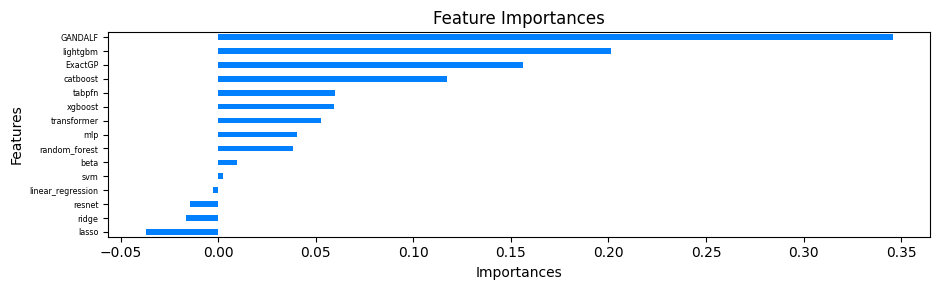

In [215]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.4)  # Adjust the height for spacing
# Increase figure height to accommodate the spacing
plt.gcf().set_size_inches(10, max(2, len(feature_importances) * 0.2))

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.margins(y=0.01) # Include margins adjustment to remove extra whitespace
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')


plt.show()

5-fold CV

In [218]:
features = pd.concat([training_predictions, test_predictions], axis=0, ignore_index=True)
features

,mlp,resnet,transformer,random_forest,svm,xgboost,lightgbm,catboost,lasso,linear_regression,ridge,ExactGP,tabpfn,GANDALF,beta
0,0.297336,0.003034,0.083570,0.085073,0.259998,0.087159,0.096149,0.065221,0.280091,0.147726,0.200306,0.064798,0.081902,0.067501,0.232964
1,0.560364,0.473622,0.288102,0.651730,0.407463,0.537473,0.477985,0.520107,0.431302,0.363599,0.426023,0.530702,0.582797,0.548563,0.528458
2,0.806250,0.827493,0.849690,0.894259,0.891207,0.915407,0.859127,0.871453,0.736495,0.859616,0.761234,0.875019,0.908666,0.864264,0.810991
3,0.808729,0.961694,0.872598,0.940343,0.826876,0.997367,1.003401,1.010926,0.659543,0.775557,0.767175,1.001151,0.949204,0.926075,0.696612
4,0.730610,1.035393,1.073326,0.982974,0.898631,1.034883,0.986328,1.067743,0.778886,0.925603,0.870509,1.027771,0.999565,0.964049,0.885558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,0.555993,0.477024,0.509075,0.458834,0.556056,0.445252,0.465124,0.454338,0.634401,0.554469,0.538156,0.388851,0.426308,0.404495,0.722923
1721,0.833832,0.747041,0.770893,0.662685,0.556595,0.749823,0.752200,0.662550,0.642449,0.537340,0.615328,0.751001,0.692249,0.777478,0.718941
1722,0.270032,0.257578,0.145832,0.278847,0.437468,0.260451,0.259769,0.228492,0.500132,0.394334,0.472023,0.235775,0.284688,0.400501,0.464447
1723,0.814986,0.728959,0.638752,0.725210,0.701506,0.766238,0.695688,0.826435,0.699259,0.883359,0.733944,0.790566,0.703393,0.503800,0.737572


In [219]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [221]:
model_arg = {"max_iter": 10000,
            "tol": 1e-4,
            "random_state": 42, **best_params}

In [227]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features.to_numpy(), labels.to_numpy(), n_folds=5, model=ElasticNet, model_params=model_arg, output_path=OUTPUT_PATH, name="meta_learner")





100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


In [228]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.34011017491896023
Training average mean absolute percentage error: 3591.6944126210933
Training average root mean squared error: 0.20877249110780505
Training average R2: 0.6036857707652585


In [229]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3398470402942332
Test average mean absolute percentage error: 3669.801372731398
Test average root mean squared error: 0.21004469750478955
Test average R2: 0.5974743708155918
